# K Nearest Neighbors classification

1. Binary classification with KNN from sklearn
2. Multi-class classifiction with KNN from sklearn
3. Multi-class classification with KNN from scratch

Sources:
* https://towardsdatascience.com/how-to-apply-machine-learning-and-deep-learning-methods-to-audio-analysis-615e286fcbbc
* https://www.analyticsvidhya.com/blog/2021/04/simple-understanding-and-implementation-of-knn-algorithm/
* https://machinelearningmastery.com/tutorial-to-implement-k-nearest-neighbors-in-python-from-scratch/

In [43]:
import sys, os, re, gzip, json, pickle, shutil, random, joblib, math

import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

from sklearn.model_selection import train_test_split

%matplotlib inline
%config IPCompleter.greedy=True
%config Completer.use_jedi = False



## Load in dataset with mapped genres. 

In [2]:
# paths
metadata_path = 'C:/Users/mplat/OneDrive - Northeastern University/metadata.json.gz'
genre_map_path = 'C:/Users/mplat/OneDrive - Northeastern University/genre_map.pkl'
mfcc_path = 'C:/Users/mplat/OneDrive - Northeastern University/mfcc'

In [3]:
# choose two binary genres to start
binary_genres = ['metal', 'classical']
lab_idx = {g:i for i,g in enumerate(binary_genres)}
lab_idx

{'metal': 0, 'classical': 1}

In [4]:
# genre counts
genre_cts = {}
for genre in os.listdir(mfcc_path):
    genre_path = '%s/%s' % (mfcc_path, genre)
    if genre == 'desktop.ini':
        continue
    genre_cts[genre] = len(os.listdir(genre_path))
    
# number samples for genre that has min samples in binary list (out of metal adn classical)
min_recs = min([genre_cts[g] for g in binary_genres])    

# print counts for each genre
for g in sorted(genre_cts, key=genre_cts.get, reverse=True):
    print(g, genre_cts[g])

rock 13158
metal 8782
alternative 8778
rap 5906
dance 5624
pop 4684
jazz 4552
hip_hop 4526
experimental 3686
other 3544
world 2225
electronic 2127
folk 1804
punk 1729
blues 1472
ambient 1299
reggae 1114
goth 722
acoustic 678
country 533
house 512
classical 486
spiritual 369
oldies 248
progressive 221
funk 142
easy_listening 131
spoken_word 130
bluegrass 48
industrial 44
showtunes 38
disco 23


In [5]:
# get list of all 32 final genres
genres = list(genre_cts.keys())
print(genres)

['acoustic', 'alternative', 'ambient', 'bluegrass', 'blues', 'classical', 'country', 'dance', 'disco', 'easy_listening', 'electronic', 'experimental', 'folk', 'funk', 'goth', 'hip_hop', 'house', 'industrial', 'jazz', 'metal', 'oldies', 'other', 'pop', 'progressive', 'punk', 'rap', 'reggae', 'rock', 'showtunes', 'spiritual', 'spoken_word', 'world']


In [6]:
# loading in the metadata and genre map
# metadata not used in this model, but could be utilized, also has original genres before mapping
with gzip.open(metadata_path, 'rt', encoding='utf-8') as fz:
    metadata = json.load(fz)

with open(genre_map_path, 'rb') as f:
    genre_map = pickle.load(f)
    
#example metadata
kys = list(metadata.keys())
ky=kys[0]
ky, metadata[ky]

('46/std_1f69563352d19cb0132334cd0d3adeaf.mp3',
 {'song_name': 'big_yellow_moon',
  'artist_name': 'bill_nelson',
  'mp3_zipname': '46',
  'mp3_filename': 'std_1f69563352d19cb0132334cd0d3adeaf.mp3',
  'genres': ['rock', 'electronica', 'alternative']})

In [7]:
# show min recs (the samples we will take from each of the binary classes to 
# avoid imbalanced data)
min_recs

486

## Feature Extraction

First look at the mfcc lengths across the data in the two classes we are working with. Then, extract mfccs and process them (so they are all the same shape) to use as features. 

In [8]:
def get_mfcc_lengths(mfcc_path, genres, max_recs):
    
    # mfcc path --> where mfcc files are located by genre
    # genres is list of geners we are working with
    # should max recs be min recs??
    
    widths=[] # holds the lens of each np array (for each song) --> folumns
    heights = [] # rows
    
    for genre in genres:
        genre_path = '%s/%s' % (mfcc_path, genre) # get path to all song mfccs in current genre
        ct = 0
        file_errors = 0
        for fn in os.listdir(genre_path): # for each song mfcc (only do as many songs as min genre so classes are even)
            fp = '%s/%s' % (genre_path, fn) # path to mfcc
            try:
                mfcc = np.load(fp) # load the np file
                widths.append(mfcc.shape[1]) # get the number of columns in the np array
                heights.append(mfcc.shape[0]) # get heights of the np array
                ct+=1
            except:
                file_errors += 1
            if ct>=max_recs:
                break
            
    # files that aren't loaded by onedrive won't read in
    print('Missed files: ', file_errors)
    l = np.array(widths)
    h = np.array(heights)
    
    return l, h

Missed files:  0
Mean mfcc widths: 9853.0833, std: 4784.7813
Mean mfcc height: 20.0000, std: 0.0000
Height histogram


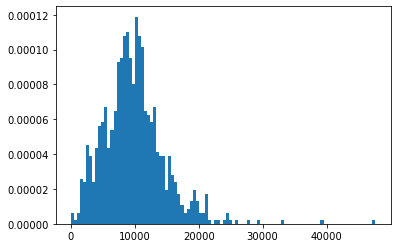

In [9]:
l, h = get_mfcc_lengths(mfcc_path, binary_genres, min_recs)

print('Mean mfcc widths: %.4f, std: %.4f' % (l.mean(), l.std())) #11098.8838, std: 4614.7522
print('Mean mfcc height: %.4f, std: %.4f' % (h.mean(), h.std())) #11098.8838, std: 4614.7522

print('Height histogram')
plt.hist(l, bins=100, density=True)
plt.show()

In [10]:
print('Max mfcc width: ', l.max())
print('Max mfcc height: ', h.max())

Max mfcc width:  47614
Max mfcc height:  20


In [11]:
def shuffle_data(x, y):
    idx = np.arange(x.shape[0])
    np.random.shuffle(idx)
    x = x[idx]
    y = y[idx]
    
    return x, y


def normalize_data(x):
    return (x-x.mean())/x.std()


def get_mfccs(mfcc_path, genres, lab_idx, max_recs):
    '''
    Open and process mfcc and return as x and y arrays.
    '''
    
    # save all x and y values
    mfccs = []
    y=[]
    i = 0
    
    # loop over each genre we are working with
    for genre in genres:
        
        # extract path to all song mfccs in current genre
        genre_path = '%s/%s' % (mfcc_path, genre)
        ct = 0
        
        # loop over each mfcc in current genre
        for fn in os.listdir(genre_path): 
            
            i += 1
            # get path to mfcc
            fp = '%s/%s' % (genre_path, fn)
            
            # load mfcc and transpose/take mean
            mfcc = np.load(fp) 
            mfcc = np.mean(mfcc.T,axis=0)
            mfccs.append(mfcc)
            
            # append target label to list
            y.append(lab_idx[genre])
            
            # for creating balanced dataset
            ct+=1
            if ct>=max_recs: 
                break
           
    # normalize data and create arrays
    x = np.array(mfccs)
    x = normalize_data(x)
    y = np.array(y)
    
    return shuffle_data(x, y)

In [12]:
# 972 samples, 20 features per sample
x, y = get_mfccs(mfcc_path, binary_genres, lab_idx, min_recs)
x.shape, y.shape

((972, 20), (972,))

In [13]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
print('training: ', x_train.shape, y_train.shape)
print('testing: ', x_test.shape, y_test.shape)

training:  (777, 20) (777,)
testing:  (195, 20) (195,)


## KNN Model (sklearn library)

### Binary classification

In [15]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn import metrics
from sklearn.metrics import classification_report

In [16]:
# choose the best value of k
# The K value when test error stabilizes and is low is considered as optimal value for K

def choose_k_value():
# choose the best value of k
# The K value when test error stabilizes and is low is considered as optimal value for K

    train_errors = []
    test_errors = []

    # use values of k 1-15
    for k in range(1,15):

        # create and fit classifier
        knn= KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train, y_train)

        # predict with x_train
        y_pred_train= knn.predict(x_train)
        train_errors.append(np.mean(y_train != y_pred_train))

        # predict with x_test
        y_pred_test = knn.predict(x_test)
        test_errors.append(np.mean(y_test!= y_pred_test))

    # plt.figure(figsize(10,5))
    plt.plot(range(1,15), train_errors, label="Error from training data")
    plt.plot(range(1,15), test_errors, label="Error from testing data")
    plt.xlabel('k Value')
    plt.ylabel('Error')
    plt.legend()


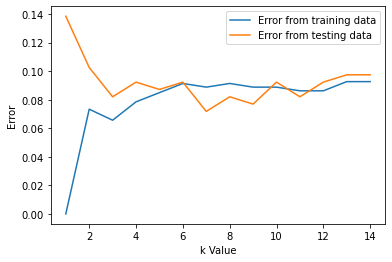

In [17]:
choose_k_value()

In [18]:
# choose 7 for optimal value of k, as that is around when test error decreases and starts to stabilize
# 7 is also lowest test error value

knn= KNeighborsClassifier(n_neighbors=7)
knn.fit(x_train, y_train)
y_pred= knn.predict(x_test)
metrics.accuracy_score(y_test,y_pred) #.93

0.9282051282051282

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93        99
           1       0.92      0.94      0.93        96

    accuracy                           0.93       195
   macro avg       0.93      0.93      0.93       195
weighted avg       0.93      0.93      0.93       195



### Multiclass classification

For simplicity, I will only use the top 5 classes and balance the dataset by using x sample from each class, where x is the number of samples in the smallest class. This will avoid having to deal with imbalanced data, but will also allow us to look at multi-class classification. The top 5 classes are:

* rock 13158
* metal 8782
* alternative 8778
* rap 5906
* dance 5624

In [20]:
top_5_genres = ['rock', 'metal', 'alternative', 'rap', 'dance']
print(top_5_genres)

['rock', 'metal', 'alternative', 'rap', 'dance']


In [21]:
lab_idx = {g:i for i,g in enumerate(top_5_genres)}
print(lab_idx)

{'rock': 0, 'metal': 1, 'alternative': 2, 'rap': 3, 'dance': 4}


In [22]:
min_recs = min([genre_cts[g] for g in top_5_genres]) 
min_recs

5624

Missed files:  0
Mean mfcc widths: 10256.8103, std: 4335.2332
Mean mfcc height: 20.0000, std: 0.0000
Height histogram


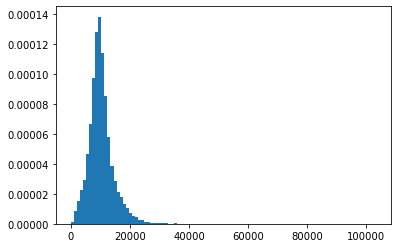

In [45]:
# get the mfcc lengths
l, h = get_mfcc_lengths(mfcc_path, top_5_genres, min_recs)

print('Mean mfcc widths: %.4f, std: %.4f' % (l.mean(), l.std())) #11098.8838, std: 4614.7522
print('Mean mfcc height: %.4f, std: %.4f' % (h.mean(), h.std())) #11098.8838, std: 4614.7522

print('Height histogram')
plt.hist(l, bins=100, density=True)
plt.show()

In [46]:
print('Max mfcc width: ', l.max())
print('Max mfcc height: ', h.max())

Max mfcc width:  103101
Max mfcc height:  20


In [48]:
# save l and h in a pickle (takes a long time to run)
w_file = open('mfcc_widths_top_5_genres', 'ab')
pickle.dump(l, w_file)  
w_file.close()

h_file = open('mfcc_heights_top_5_genres', 'ab')
pickle.dump(h, h_file) 
h_file.close()

In [23]:
# should be this many samples
5624 * 5

28120

In [24]:
# ((28120, 20), (28120,))
x, y = get_mfccs(mfcc_path, top_5_genres, lab_idx, min_recs)
x.shape, y.shape

((28120, 20), (28120,))

In [25]:
# save x and y in a pickle (takes a long time to run)
x_file = open('mfcc_x_top_5_genres', 'ab')
pickle.dump(x, x_file)  
x_file.close()

y_file = open('mfcc_y_top_5_genres', 'ab')
pickle.dump(y, y_file) 
y_file.close()

In [26]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [27]:
print('training: ', x_train.shape, y_train.shape)
print('testing: ', x_test.shape, y_test.shape)

training:  (22496, 20) (22496,)
testing:  (5624, 20) (5624,)


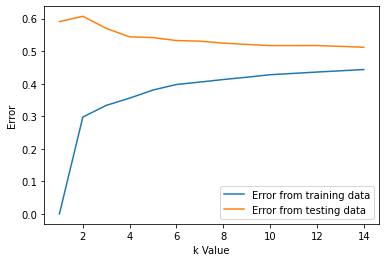

In [28]:
# choose best value of k
choose_k_value()

In [30]:
# it still looks like 14 is the best value of k to use
knn= KNeighborsClassifier(n_neighbors=14)
knn.fit(x_train, y_train)
y_pred= knn.predict(x_test)
metrics.accuracy_score(y_test,y_pred) #.49

0.4880867709815078

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.38      0.36      1129
           1       0.61      0.63      0.62      1129
           2       0.38      0.34      0.36      1093
           3       0.63      0.55      0.59      1161
           4       0.50      0.53      0.52      1112

    accuracy                           0.49      5624
   macro avg       0.49      0.49      0.49      5624
weighted avg       0.49      0.49      0.49      5624



Overall, performance is not excellent. It is best with predicting class 1 (metal) and class 3 (rap). Perhaps more features would help. It's also notable that the genres chosen are pretty close together and not so clear cut (i.e., a song could be considered both rock and alternative by a human rater). I'll now choose 5 genres that I would consider more diverse. 

* rock 13158
* jazz 4552
* rap 5906
* pop 4684
* hip_hop 4526



In [32]:
diverse_genres = ['rock', 'jazz', 'rap', 'pop', 'hip_hop']
print(diverse_genres)

['rock', 'jazz', 'rap', 'pop', 'hip_hop']


In [33]:
lab_idx = {g:i for i,g in enumerate(diverse_genres)}
print(lab_idx)

{'rock': 0, 'jazz': 1, 'rap': 2, 'pop': 3, 'hip_hop': 4}


In [34]:
min_recs = min([genre_cts[g] for g in diverse_genres]) 
min_recs

4526

In [35]:
# we should have this many total samples
4526 * 5

22630

In [36]:
x, y = get_mfccs(mfcc_path, diverse_genres, lab_idx, min_recs)
x.shape, y.shape # ((22630, 20), (22630,))

((22630, 20), (22630,))

In [37]:
# save x and y in a pickle (takes a long time to run)
x_file = open('mfcc_x_diverse', 'ab')
pickle.dump(x, x_file)  
x_file.close()

y_file = open('mfcc_y_diverse', 'ab')
pickle.dump(y, y_file) 
y_file.close()

In [38]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [39]:
print('training: ', x_train.shape, y_train.shape)
print('testing: ', x_test.shape, y_test.shape)

training:  (18104, 20) (18104,)
testing:  (4526, 20) (4526,)


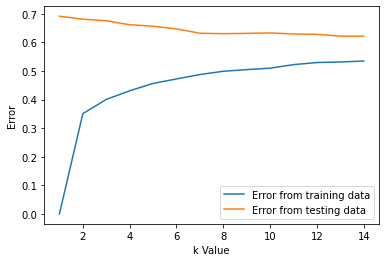

In [40]:
# choose best value of k
choose_k_value()

In [41]:
# looks like around k=14 is where the test error levels out
knn= KNeighborsClassifier(n_neighbors=14)
knn.fit(x_train, y_train)
y_pred= knn.predict(x_test)
metrics.accuracy_score(y_test, y_pred) 

0.377817057003977

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.51      0.46       913
           1       0.37      0.44      0.40       941
           2       0.45      0.45      0.45       934
           3       0.31      0.26      0.28       891
           4       0.29      0.21      0.25       847

    accuracy                           0.38      4526
   macro avg       0.37      0.37      0.37      4526
weighted avg       0.37      0.38      0.37      4526



Accuracy actually decreased with this group of classes. The class best classifier were class 0 (rock) and class 2 (rap). Perhaps, time permitting, we will try to improve the model by adding/replacing the mfcc features. 

## KNN Model (from scratch)

In [118]:
import statistics
from statistics import mode
from heapq import nlargest

In [124]:
def calculate_distance(x_1, x_2):
    '''
    Calculate the distance between one sample and another sample
    '''
    return np.sqrt(np.sum(np.square(x_1-x_2)))

def calculate_nearest_neightbors(current_sample, k):
    '''
    Calculate distances between a sample and all other samples, to find the k closest samples.
    '''
    all_distances = {} # i is the compared training sample : distance to current test sample
    for i in range(len(x_train)):
        temp_distance = calculate_distance(current_sample, x_train[i])
        all_distances[i] = temp_distance
        
    nn_indices = nlargest(k, all_distances, key=all_distances.get)
            
    return nn_indices
        
def predict(k):
    
    # store predictions for each test sample here
    predictions = []
    
    # for each test sample...
    for i in range(len(x_test)):
        
        # get the train samples that it is nearest
        temp_nn_indicies = calculate_nearest_neightbors(x_test[i], k) # [ (idx_of_sample, [sample]), ... ]
        
        # use the index to look up the sample in the training data, and get the target value
        temp_preds = []
        for j in range(len(temp_nn_indicies)):
            current_index = temp_nn_indicies[j]
            temp_preds.append(y_train[current_index])
        
        # find the most frequent class that the sample was near in the training data (this is the prediction)
        predictions.append(mode(temp_preds))
        
    return predictions
    

Compare implementation from scratch performance to that from sklearn libraries. 

In [135]:
binary_genres

['metal', 'classical']

In [128]:
lab_idx = {g:i for i,g in enumerate(binary_genres)}
min_recs = min([genre_cts[g] for g in binary_genres]) 

In [129]:
x, y = get_mfccs(mfcc_path, binary_genres, lab_idx, min_recs)
x.shape, y.shape

((972, 20), (972,))

In [130]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [142]:
y_preds = predict(7)

In [143]:
metrics.accuracy_score(y_test, y_preds) 

0.22564102564102564

In [144]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       104
           1       0.30      0.48      0.37        91

    accuracy                           0.23       195
   macro avg       0.15      0.24      0.18       195
weighted avg       0.14      0.23      0.17       195

